In [75]:
# import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


# set up the figure size
%matplotlib inline

# import data file
file_path = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/ab_data.csv'
test_data = pd.read_csv(file_path)

# Goal and Hypothesis:
The goal of this A/B test is to determine if redesgining the landing page for X website would increase user conversion rate. Hypothesis: changing the landing page design will increase user conversion rate.

Website users are assigned to control (seeing the old landing page) or treatment (seeing the new landing page) randomly when visiting the website. Conversion rate is measure for each user. In addition, user-id and time stamp will be collected for each landing site visit. 

A successful landing page will increase conversion rate by 50% more than the old layout.

Power test (to be calculated)

Duration long enough to collect sample size calculated

Test for systematic bias by running A/A test (cannot subgroup in this particular case)


***
## 1. Sanity chek
### 1.1. Is any of the data duplicated? 

In [29]:
nrow = test_data.shape[0]
nunique = test_data.user_id.nunique()
print('There is {} rows'.format(nrow))
print('{} of those correspond to unique user ids'.format(nunique))
print('Which means, {} entries are duplicated'.format(nrow-nunique))

There is 294478 rows
290584 of those correspond to unique user ids
Which means, 3894 entries are duplicated


### Removing duplicates. Keeping only first istance for each user

In [30]:
test_data.drop_duplicates(subset='user_id', keep='first', inplace=True)

In [31]:
nrow = test_data.shape[0]
nunique = test_data.user_id.nunique()
print('There is {} rows'.format(nrow))
print('{} of those correspond to unique user ids'.format(nunique))
print('Which means, {} entries are duplicated'.format(nrow-nunique))

There is 290584 rows
290584 of those correspond to unique user ids
Which means, 0 entries are duplicated


### 1.2. Is all data assigned correctly?

In [50]:
error1 = test_data[(test_data['group']=='control') & (test_data['landing_page']=='new_page')].shape[0]/test_data[(test_data['group']=='control')].shape[0]
error2 = test_data[(test_data['group']=='treatment') & (test_data['landing_page']=='old_page')].shape[0]/test_data[(test_data['group']=='treatment')].shape[0]
print('{:.2}% of control group is assigned "new page" and {:.2}% of treatment group is assigned "old page"'.format(error1*100, error2*100))

0.0% of control group is assigned "new page" and 0.0% of treatment group is assigned "old page"


In [48]:
### remove users that have conflicting assignments and save them in seperate dataframe
exc_nrow = exclude.shape[0]
filtered_nrow = test_data.shape[0]
exclude = test_data.loc[((test_data['group']=='control')&(test_data['landing_page']=='new_page'))|((test_data['group']=='treatment')&(test_data['landing_page']=='old_page'))]
print('{} users that have be assigned the wrong page and will be excluded'.format(exc_nrow))
test_data.drop(exclude.index, inplace=True)
print('Which leaves {} ({:.4}%) users.'.format(filtered_nrow, filtered_nrow/(filtered_nrow+exc_nrow)*100))

2044 users that have be assigned the wrong page and will be excluded
Which leaves 288540 (99.3%) users.


## 2. Statistical Check
### 2.1. What's the probability that a user is converted regardless of landing page layout?

In [47]:
p_converted = test_data.converted.sum()/test_data.shape[0]
print('{:.4}% of users from both control and treatment groups converted'. format(p_converted*100))

11.95% of users from both control and treatment groups converted


### 2.2. What's the probability of conversion, given the user was part of the _control_ group?

In [55]:
p_control_converted = test_data.query('group == "control"')['converted']
p_control_converted = p_control_converted.sum()/p_control_converted.shape[0]
print('{:.4}% of users in control group converted'. format(p_control_converted*100))

12.03% of users in control group converted


### 2.3. What's the probability of conversion, given the user was part of the _treatment_ group?

In [57]:
p_treat_converted = test_data.query('group == "treatment"')['converted']
p_treat_converted = p_treat_converted.sum()/p_treat_converted.shape[0]
print('{:.4}% of users in control group converted'. format(p_treat_converted*100))

11.87% of users in control group converted


### 2.4. Barplot visualization of 2.1 - 2.3:

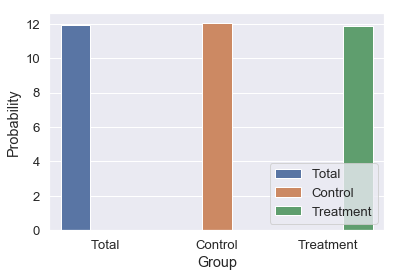

In [73]:
barplot_data = pd.DataFrame({'Probability' : (p_converted*100, p_control_converted*100, p_treat_converted*100), 'Group' : ('Total', 'Control', 'Treatment')})
sns.set_style('whitegrid')
sns.set(font_scale=1.2)
sns.barplot(y = 'Probability', x = 'Group', hue = 'Group', data=barplot_data)
plt.legend(loc='lower right')

### 2.5. Conclusion from part 2:
Based on the analysis above, there is no sufficient evidence to show that the new landing page increases user conversion rate. The results show that there is even a slight decrease in conversion rate when compared to the old landing page.

## 3. Power test
### 3.1. Is the sample size big enough to detect a change?

In [87]:
# Source: http://stackoverflow.com/questions/15204070/is-there-a-python-scipy-function-to-determine-parameters-needed-to-obtain-a-ta

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

n = sample_power_probtest(0.12, 0.15, power=0.9, sig=0.05)
print("The sample size required to detect a 3% increase from control conversion rate is {}, \nwhich is 5-fold smaller than the study's sample size".format(n))

The sample size required to detect a 3% increase from control conversion rate is 2727, 
which is 5-fold smaller than the study's sample size


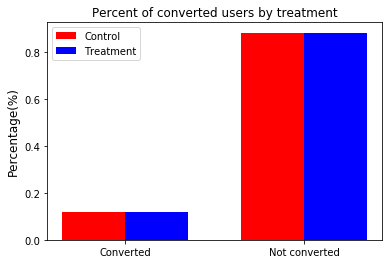

In [26]:
## Prepare data for plotting
grouped_conversion = test_data.groupby(['group', 'converted']).count() #counts grouped by group (control/ treat) and converted
grouped_conversion = grouped_conversion / grouped_conversion.groupby(level=0).sum() # convert to percentages
unstacked_conversion = grouped_conversion['user_id'].unstack() 
#generating plot
N = 2
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
width = 0.35          # the width of the bars
p1 = ax.bar(ind, unstacked_conversion.iloc[1][::-1], width, color='r')
p2 = ax.bar(ind + width, unstacked_conversion.iloc[0][::-1], width, color='b')
# labeling and customizing plot
ax.set_title('Percent of converted users by treatment', fontsize='large')
ax.set_ylabel('Percentage(%)', fontsize='large')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Converted', 'Not converted'))
ax.legend((p1[0], p2[0]), ('Control', 'Treatment'))
plt.grid(b=False)
plt.show()

In [24]:
unstacked_conversion

converted,0,1
group,,
control,0.879601,0.120399
treatment,0.881080,0.118920
